In [366]:
# импорт необходимых модулей, классов, функций

import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import textwrap as tw

from itertools import product
from scipy.cluster.hierarchy import dendrogram

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE

In [165]:
# Загрузка датасета в DataFrame

with open('youtuberesults.csv', 'r') as file:
    df_orig = pd.read_csv(file).sample(frac=1,random_state=42, ignore_index=True).dropna()

print(f'Количество образцов в исходном наборе: {df_orig.shape[0]}')

# Примеры комментариев 
df_orig.textOriginal[:5].to_list()


Количество образцов в исходном наборе: 36016


['Респект за видео, где понятным и простым языком все объяснили. \nОтдельный респект за музон 👍.',
 'Новые и современные клички для вас : Вася Чушпан и Денис Скорлупа.',
 'Больше болтает  про валик, чем показывает',
 'Увидел Алису в метро, еще красивее стала!😊',
 'А, самое главное сколько единомышленников в коментах проплачено! Никто видимо ничего не понял, час из часа не послушал, но лайк поставил! Или я не догоняю, здесь собрались все высокие умы этого государства? Аналитики, маркетологи, экономисты, юристы, практологи, гастроэнтерологи... и САМОЕ ГЛАВНОЕ КИДАЛОВЫ! Народ, ну вот реально лайкните , кто этот бред слушал, да еще до конца дослушал!??? Это у Пьянчук с дома терпимости, какая то такая же мошеннеческая разводная схема была.']

## 1. Предобработка данных

In [166]:
# Очищение комментариев от небуквенных символов 
def preprocessor(text: str) -> str:
    """
    Функция находит в строке все некириллические символы и заменяет их на пробел.
    После чего, приводит все слова в строке к нижнему регистру.

    Args:
        text (str): Неотредактированная строка

    Returns:
        text (str): Строка в нижнем регистре, состоящая только из буквенных символов
    """
    text = re.sub('[^А-ЯЁа-яё]+', ' ', text.lower())
    return text
df = df_orig.copy()
df.textOriginal = df.textOriginal.apply(preprocessor)
df.textOriginal[:5].to_list()

['респект за видео где понятным и простым языком все объяснили отдельный респект за музон ',
 'новые и современные клички для вас вася чушпан и денис скорлупа ',
 'больше болтает про валик чем показывает',
 'увидел алису в метро еще красивее стала ',
 'а самое главное сколько единомышленников в коментах проплачено никто видимо ничего не понял час из часа не послушал но лайк поставил или я не догоняю здесь собрались все высокие умы этого государства аналитики маркетологи экономисты юристы практологи гастроэнтерологи и самое главное кидаловы народ ну вот реально лайкните кто этот бред слушал да еще до конца дослушал это у пьянчук с дома терпимости какая то такая же мошеннеческая разводная схема была ']

In [167]:
# Удаление стоп-слов

stop_words = stopwords.words('russian')

def remove_stop_words(text: str) -> str:
    """
    Убирает из строки стоп-слова согласно списку библиотеки nltk

    Args:
        text (str): Исходная строка

    Returns:
        str: Строка без стоп-слов
    """
    return ' '.join([word for word in text.split() if word not in stop_words])

df.textOriginal = df.textOriginal.apply(remove_stop_words)
df.textOriginal[:5].to_list()

['респект видео понятным простым языком объяснили отдельный респект музон',
 'новые современные клички вася чушпан денис скорлупа',
 'болтает валик показывает',
 'увидел алису метро красивее стала',
 'самое главное сколько единомышленников коментах проплачено никто видимо понял час часа послушал лайк поставил догоняю собрались высокие умы государства аналитики маркетологи экономисты юристы практологи гастроэнтерологи самое главное кидаловы народ реально лайкните бред слушал конца дослушал это пьянчук дома терпимости такая мошеннеческая разводная схема']

In [171]:
# Стеммирование

stemmer = SnowballStemmer('russian')

def stemming_tokenizer(text: str) -> str:
    """
    Стеммирует слова в строке. Для стемирования использует алгоритм SnowballStemmer.

    Args:
        text (str): Исходная строка

    Returns:
        str: Строка со стеммированными словами
    """
    return ' '.join([stemmer.stem(word) for word in text.split()])

df.textOriginal = df.textOriginal.apply(stemming_tokenizer)
df.textOriginal[:5].to_list()

['респект виде понятн прост язык объясн отдельн респект музон',
 'нов современ кличк ва чушпа денис скорлуп',
 'болта валик показыва',
 'увидел алис метр красив стал',
 'сам главн скольк единомышленник комент проплач никт видим поня час час послуша лайк постав догоня собра высок ум государств аналитик маркетолог экономист юрист практолог гастроэнтеролог сам главн кидалов народ реальн лайкн бред слуша конц дослуша эт пьянчук дом терпим так мошеннеческ разводн схем']

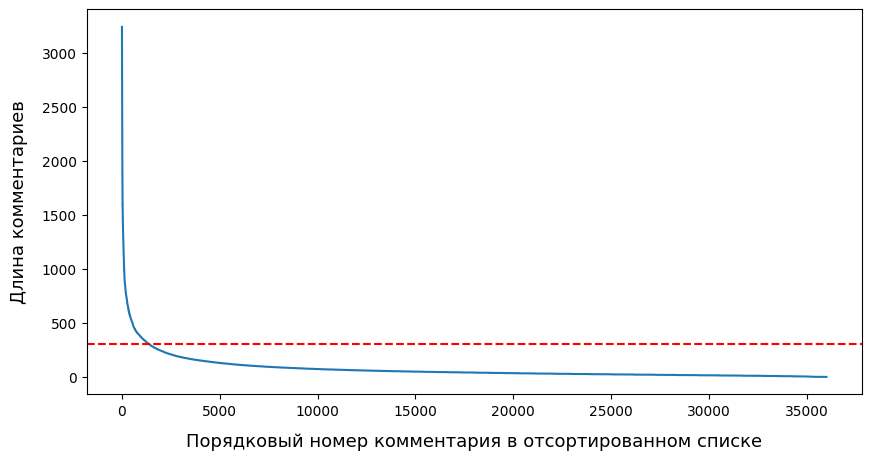

In [172]:
# Оценка длины комментариев

plt.figure(figsize=(10,5))
plt.plot(range(df.shape[0]), df.textOriginal.apply(len).sort_values(ascending=False).to_numpy())
plt.axhline(300, color='r', linestyle='--')
plt.ylabel('Длина комментариев', size=13, labelpad=10)
plt.xlabel('Порядковый номер комментария в отсортированном списке', size=13, labelpad=10)
plt.show()

In [173]:
# Из графика видно, что подавляющее число комментариев имеет длину менее 300 символов. Слишком короткие также следует убрать.

df = df[(df.textOriginal.str.len() > 2) & (df.textOriginal.str.len() < 300)]
print(f'Количество образцов в наборе: {df.shape[0]}')

Количество образцов в наборе: 33767


In [174]:
# Для сокращения времени обучения моделей оставим в датасете 10 000 образцов

df_sample = df.sample(10000, random_state=42)

In [175]:
# Инициализация векторизатора

embedding_model = SentenceTransformer('intfloat/multilingual-e5-large')

In [213]:
# Векторизация корпуса документов

def multilingual_e5_large_tokenizer(corpus):
    X_new = embedding_model.encode('query: ' + corpus[0], normalize_embeddings=True)
    
    for text in corpus[1:]:
        embeddings = embedding_model.encode('query: ' + text, normalize_embeddings=True)
        X_new = np.vstack((X_new, embeddings))
       
    return X_new 

In [11]:
X_m5 = multilingual_e5_large_tokenizer(df_sample.textOriginal)
print(f'Размерность матрицы объекты-признаки {X_m5.shape}')

Размерность матрицы объекты-признаки (10000, 1024)


In [15]:
# Запись матрицы объекты признаки в файл

with open('X_m5.npy', 'wb') as file:
    np.save(file, X_m5, allow_pickle=False)

In [152]:
# Чтение матрицы объекты признаки из файла

with open('X_m5.npy', 'rb') as file:
   X_m5 = np.load(file, allow_pickle=False)

In [157]:
def reduce_dim(X, sigm: float = 0.8):
    """
    Определяет оптимальное количество главных компонент для сохранения заданного порога объясненной дисперсии

    Args:
        X (array-like) of shape (n_samples, n_features): Исходный массив
        sigm (float): Порог объясненной дисперсии, default=0.8

    Returns:
        X_new (array-like) of shape (n_samples, n_components): Спроецированный массив
    """
    reducer = PCA(n_components=X.shape[1], random_state=42)
    reducer.fit(X)
    opt_n_pc = np.count_nonzero(np.cumsum(reducer.explained_variance_ratio_) < sigm)
    opt_reducer = PCA(opt_n_pc, random_state=42)
    return opt_reducer.fit_transform(X)

In [358]:
# Понижение размерности пространства признаков при 90% объясненной дисперсии

X_m5_reduce = reduce_dim(X_m5, 0.9)
print(f'Новая размерность матрицы объекты-признаки" {X_m5_reduce.shape}')

Новая размерность матрицы объекты-признаки" (10000, 306)


## 2. Обучение моделей

### 2.1 k-means

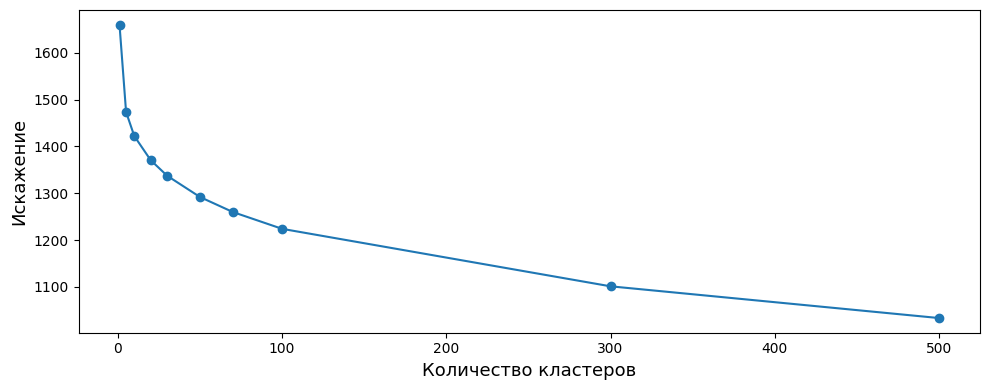

In [352]:
# "Метод локтя" для определения оптимального количества кластеров

distortions = []

for i in [1, 5, 10, 20, 30, 50, 70, 100, 300, 500]:
    km = KMeans(n_clusters=i, n_init=10,random_state=42)
    km.fit(X_m5_reduce)
    distortions.append(km.inertia_)

plt.figure(figsize=(10, 4))
plt.plot([1, 5, 10, 20, 30, 50, 70, 100, 300, 500], distortions, marker='o') 
plt.xlabel('Количество кластеров', size=13)
plt.ylabel('Искажение', size=13)
plt.tight_layout()
plt.show()

Несмотря на отсутствие характерного излома на графике, примерно после n_cluster = 30 темпы уменьшения метрики начинают снижаться. Для k-means n_cluster принято равным 30.

In [359]:
km_opt = KMeans(n_clusters=30, n_init=10, random_state=42)
labels_km = km_opt.fit_predict(X_m5_reduce)

In [360]:
# Определение метрик качества кластеризации 

print(f'Коэффициент силуэта: {silhouette_score(X_m5_reduce, labels_km) :.2f}')
print(f'Индекс Дэвиcа-Болдуина: {davies_bouldin_score(X_m5_reduce, labels_km) :.2f}')

Коэффициент силуэта: 0.02
Индекс Дэвиcа-Болдуина: 4.61


### 2.2 AgglomerativeClustering

In [263]:
# Определения оптимального количества кластеров

ac = AgglomerativeClustering(n_clusters=1, compute_distances=True)
ac.fit(X_m5_reduce)

AgglomerativeClustering(compute_distances=True, n_clusters=1)

In [50]:
# Построение дендрограммы
# Автор функции Mathew Kallada. Источник https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py

def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = model.distances_
    no_of_observations = np.arange(2, children.shape[0] + 2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(300,100))
plot_dendrogram(ac, labels=ac.labels_, color_threshold=3)
plt.yticks(np.arange(min(ac.distances_), max(ac.distances_)+1, 0.5), size=20)
plt.show()

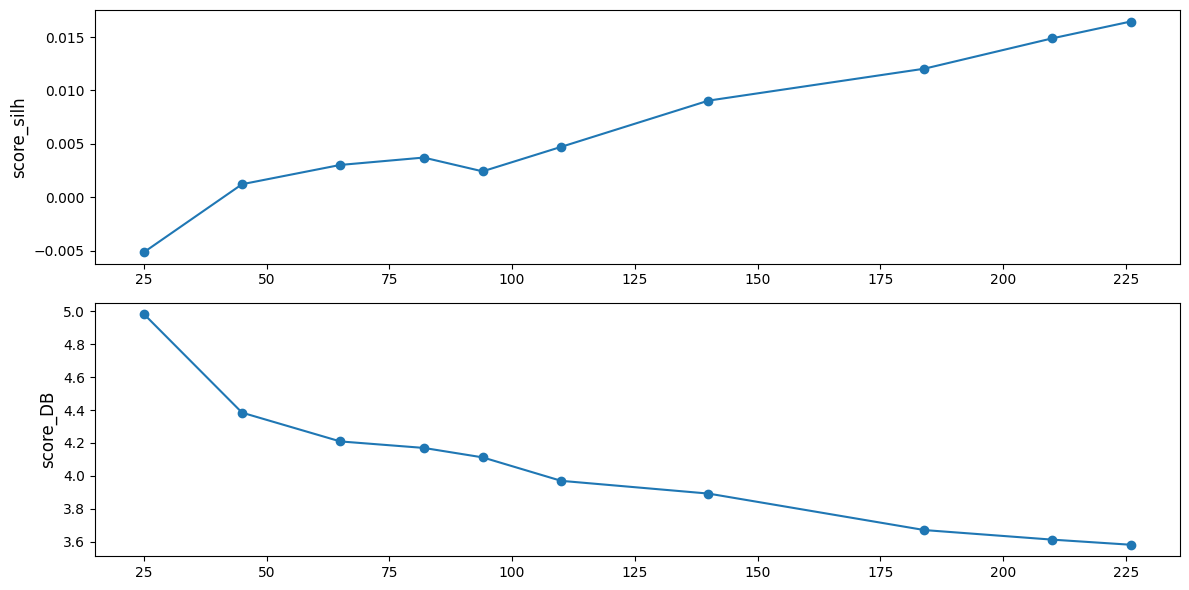

In [348]:
# Подбор оптимального количества кластеров на оснвое построенной дендрограммы

nums = [25, 45, 65, 82, 94, 110, 140, 184, 210, 226]
score_silh = []
score_DB = []

for num in nums:
    ac = AgglomerativeClustering(n_clusters=num)
    labels_ac = ac.fit_predict(X_m5_reduce)
    
    score_silh.append(silhouette_score(X_m5_reduce, labels_ac))
    score_DB.append(davies_bouldin_score(X_m5_reduce, labels_ac))
    
plt.figure(figsize=(12, 6))
ax0 = plt.subplot(2, 1, 1)
ax0.plot(nums, score_silh, marker='o')
ax0.set_ylabel('score_silh', size=12)

ax1 = plt.subplot(2, 1, 2)
ax1.plot(nums, score_DB, marker='o')
ax1.set_ylabel('score_DB', size=12)

plt.tight_layout()
plt.show()

Из графиков видно, что увеличение количества кластеров с 25 до 45 дает наилучший прирост в мтериках качества. В дальнейшем, скорость роста функций становится менее существенной. Для более интерпретируемой модели целесообразно оставить n_clusters = 45.

In [361]:
ac_opt = AgglomerativeClustering(n_clusters=45)
labels_ac = ac_opt.fit_predict(X_m5_reduce)

In [362]:
# Определение метрик качества кластеризации 

print(f'Коэффициент силуэта: {silhouette_score(X_m5_reduce, labels_ac) :.2f}')
print(f'Индекс Дэвиcа-Болдуина: {davies_bouldin_score(X_m5_reduce, labels_ac) :.2f}')

Коэффициент силуэта: 0.00
Индекс Дэвиcа-Болдуина: 4.38


### 2.3 HDBSCAN

In [374]:
# Оценка влияния отдельных гиперпараметров на качество кластеризации. Качество кластеризации оценивается с помощью среднего коэффициента силуэта и индекса Дэвиcа-Болдуина 

def many_fit(X, values, param_name: str):
    hdbscan = HDBSCAN(n_jobs=-1)
    score_silh = []
    score_DB = []
    
    for val in values:
        print(f'Текущие параметры: {param_name} = {val}',)
        hdbscan.__setattr__(param_name, val)
        hdbscan.fit(X)
        score_silh.append(silhouette_score(X[hdbscan.labels_ >= 0, :], hdbscan.labels_[hdbscan.labels_ >= 0]))
        score_DB.append(davies_bouldin_score(X[hdbscan.labels_ >= 0, :], hdbscan.labels_[hdbscan.labels_ >= 0]))
        
    
    return score_silh, score_DB

Текущие параметры: min_cluster_size = 3
Текущие параметры: min_cluster_size = 5
Текущие параметры: min_cluster_size = 10
Текущие параметры: min_cluster_size = 15
Текущие параметры: min_cluster_size = 20
Текущие параметры: min_samples = 2
Текущие параметры: min_samples = 3
Текущие параметры: min_samples = 5
Текущие параметры: min_samples = 10
Текущие параметры: min_samples = 15
Текущие параметры: min_samples = 20
Текущие параметры: cluster_selection_epsilon = 0.0
Текущие параметры: cluster_selection_epsilon = 0.1
Текущие параметры: cluster_selection_epsilon = 0.2
Текущие параметры: cluster_selection_epsilon = 0.3
Текущие параметры: cluster_selection_epsilon = 0.5


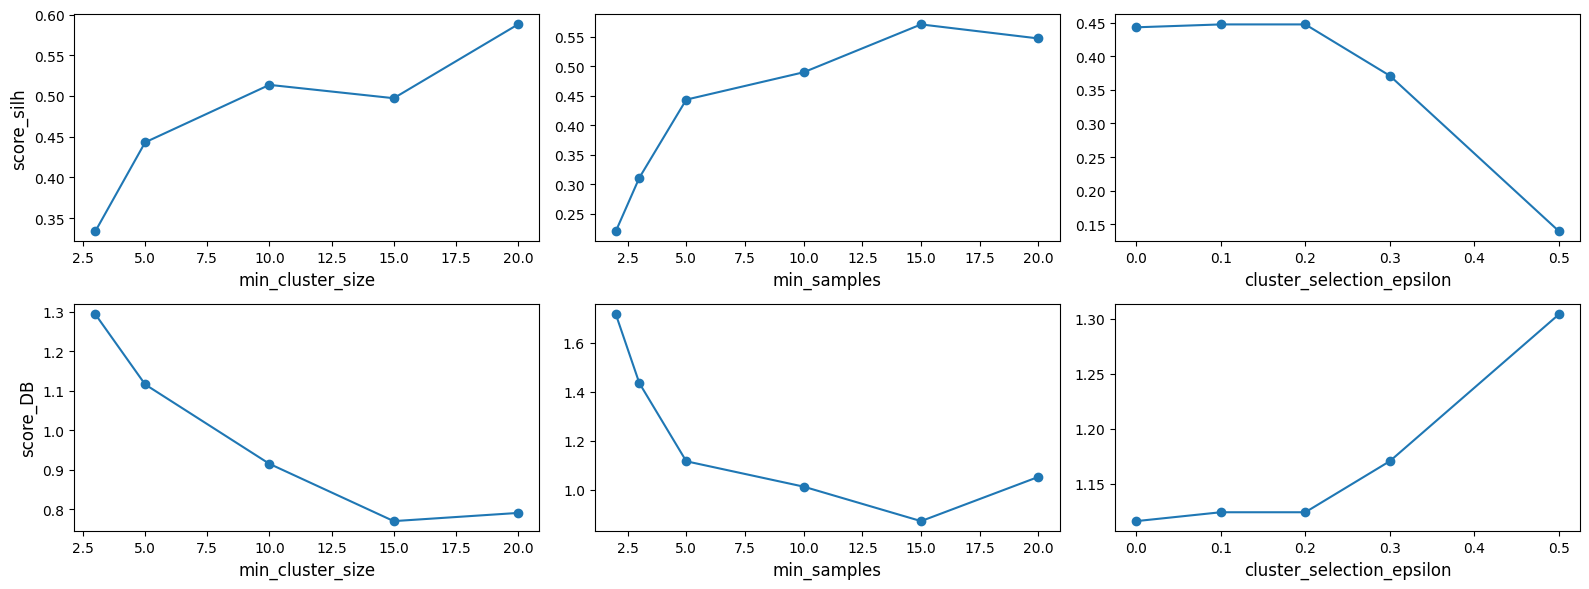

In [377]:
dict_params = {
    "min_cluster_size": [3, 5, 10, 15, 20],
    "min_samples": [2, 3, 5, 10, 15, 20],
    "cluster_selection_epsilon": [0.0, 0.1, 0.2, 0.3, 0.5] 
}
fig1 = plt.figure(figsize=(16, 6))

for i, (name, vals) in enumerate(dict_params.items()):
    score_silh, score_DB = many_fit(X_m5_reduce, vals, name)
    
    ax1 = fig1.add_subplot(2,3,i+1)
    ax1.plot(vals, score_silh, marker='o')
    ax1.set_xlabel(name, size=12)
    
    ax2 = fig1.add_subplot(2,3,i+4)
    ax2.plot(vals, score_DB, marker='o')
    ax2.set_xlabel(name, size=12)
    
    if i == 0:
        ax1.set_ylabel('score_silh', size=12)
        ax2.set_ylabel('score_DB', size=12)

plt.tight_layout()
plt.show()

In [389]:
# Подбор парааметров модели

df_score = pd.DataFrame(
    columns=[
        "min_cluster_size",
        "min_samples",
        "cluster_selection_epsilon",
        "max_cluster_size",
        "n_clasters",
        "max_cluster",
        "sum_samples",
        "silh_score",
        "DB_score"
    ]
)

for (i, j, k, m) in product((3, 5, 10, 15), (3, 5, 10, 15), (0, 0.2, 0.3), (None, 100, 200)):
    hdbscan_test = HDBSCAN(min_cluster_size=i, min_samples=j, cluster_selection_epsilon=k, max_cluster_size=m, n_jobs=-1)
    print(f"Текущие параметры: min_cluster_size={i}, min_samples={j}, cluster_selection_epsilon={k}, max_cluster_size={m}")
    hdbscan_test.fit(X_m5_reduce)
    
    n_clasters = np.unique(hdbscan_test.labels_[hdbscan_test.labels_ >= 0]).__len__()
    sum_samples = len(hdbscan_test.labels_[hdbscan_test.labels_ >= 0])
    max_cluster = np.amax(np.bincount(hdbscan_test.labels_[hdbscan_test.labels_ >= 0]))
    silh_score = silhouette_score(X_m5_reduce[hdbscan_test.labels_ >= 0, :], hdbscan_test.labels_[hdbscan_test.labels_ >= 0])
    DB_score = davies_bouldin_score(X_m5_reduce[hdbscan_test.labels_ >= 0, :], hdbscan_test.labels_[hdbscan_test.labels_ >= 0])
    
    df_score.loc[len(df_score.index)] = [i, j, k, m, n_clasters, max_cluster, sum_samples, silh_score, DB_score]

Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0, max_cluster_size=None
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0, max_cluster_size=100
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0, max_cluster_size=200
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.2, max_cluster_size=None
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.2, max_cluster_size=100
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.2, max_cluster_size=200
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.3, max_cluster_size=None
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.3, max_cluster_size=100
Текущие параметры: min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.3, max_cluster_size=200
Текущие параметры: min_cluster_size=3, min_sample

In [394]:
pd.set_option('display.max_rows', None)
df_score

min_cluster_size  min_samples  cluster_selection_epsilon  \
0                 3.0          3.0                        0.0   
1                 3.0          3.0                        0.0   
2                 3.0          3.0                        0.0   
3                 3.0          3.0                        0.2   
4                 3.0          3.0                        0.2   
5                 3.0          3.0                        0.2   
6                 3.0          3.0                        0.3   
7                 3.0          3.0                        0.3   
8                 3.0          3.0                        0.3   
9                 3.0          5.0                        0.0   
10                3.0          5.0                        0.0   
11                3.0          5.0                        0.0   
12                3.0          5.0                        0.2   
13                3.0          5.0                        0.2   
14                3.0          5.0                        0.2   
15                3.0          5.0                        0.3   
16                3.0          5.0                        0.3   
17                3.0          5.0                        0.3   
18                3.0         10.0                        0.0   
19                3.0         10.0                        0.0   
20                3.0         10.0                        0.0   
21                3.0         10.0                        0.2   
22                3.0         10.0                        0.2   
23                3.0         10.0                        0.2   
24                3.0         10.0                        0.3   
25                3.0         10.0                        0.3   
26                3.0         10.0                        0.3   
27                3.0         15.0                        0.0   
28                3.0         15.0                        0.0   
29                3.0         15.0                        0.0   
30                3.0         15.0                        0.2   
31                3.0         15.0                        0.2   
32                3.0         15.0                        0.2   
33                3.0         15.0                        0.3   
34                3.0         15.0                        0.3   
35                3.0         15.0                        0.3   
36                5.0          3.0                        0.0   
37                5.0          3.0                        0.0   
38                5.0          3.0                        0.0   
39                5.0          3.0                        0.2   
40                5.0          3.0                        0.2   
41                5.0          3.0                        0.2   
42                5.0          3.0                        0.3   
43                5.0          3.0                        0.3   
44                5.0          3.0                        0.3   
45                5.0          5.0                        0.0   
46                5.0          5.0                        0.0   
47                5.0          5.0                        0.0   
48                5.0          5.0                        0.2   
49                5.0          5.0                        0.2   
50                5.0          5.0                        0.2   
51                5.0          5.0                        0.3   
52                5.0          5.0                        0.3   
53                5.0          5.0                        0.3   
54                5.0         10.0                        0.0   
55                5.0         10.0                        0.0   
56                5.0         10.0                        0.0   
57                5.0         10.0                        0.2   
58                5.0         10.0                        0.2   
59                5.0         10.0                        0.2   
60                5.0         10.0      

По всей видимости, характер распределения данных не позволяет алгоритму HDBSCAN кластеризовать существенное количество образцов. Подавляющее количество образцов определяется как шум при различных сочетаниях гиперпараметров. Таже, возможно, для успешной кластеризации не найдены подходящие параметры или требуется другой способ предобработки.

## 3. Визуализация данных и выбор конечной модели

In [403]:
# Объявление функции для построения диаграммы рассеяния

def my_scatter(dots, labels):
    randomizer = np.random.RandomState(42)
    
    for label in np.unique(labels):
        color = tuple(randomizer.random(3))
        ax = plt.subplot()
        ax.scatter(dots[labels == label, 0], dots[labels == label, 1], s=10, color=color)
    
    return ax

In [329]:
tsne = TSNE(n_jobs=-1, angle=0.1, random_state=42)
dots = tsne.fit_transform(X_m5_reduce)

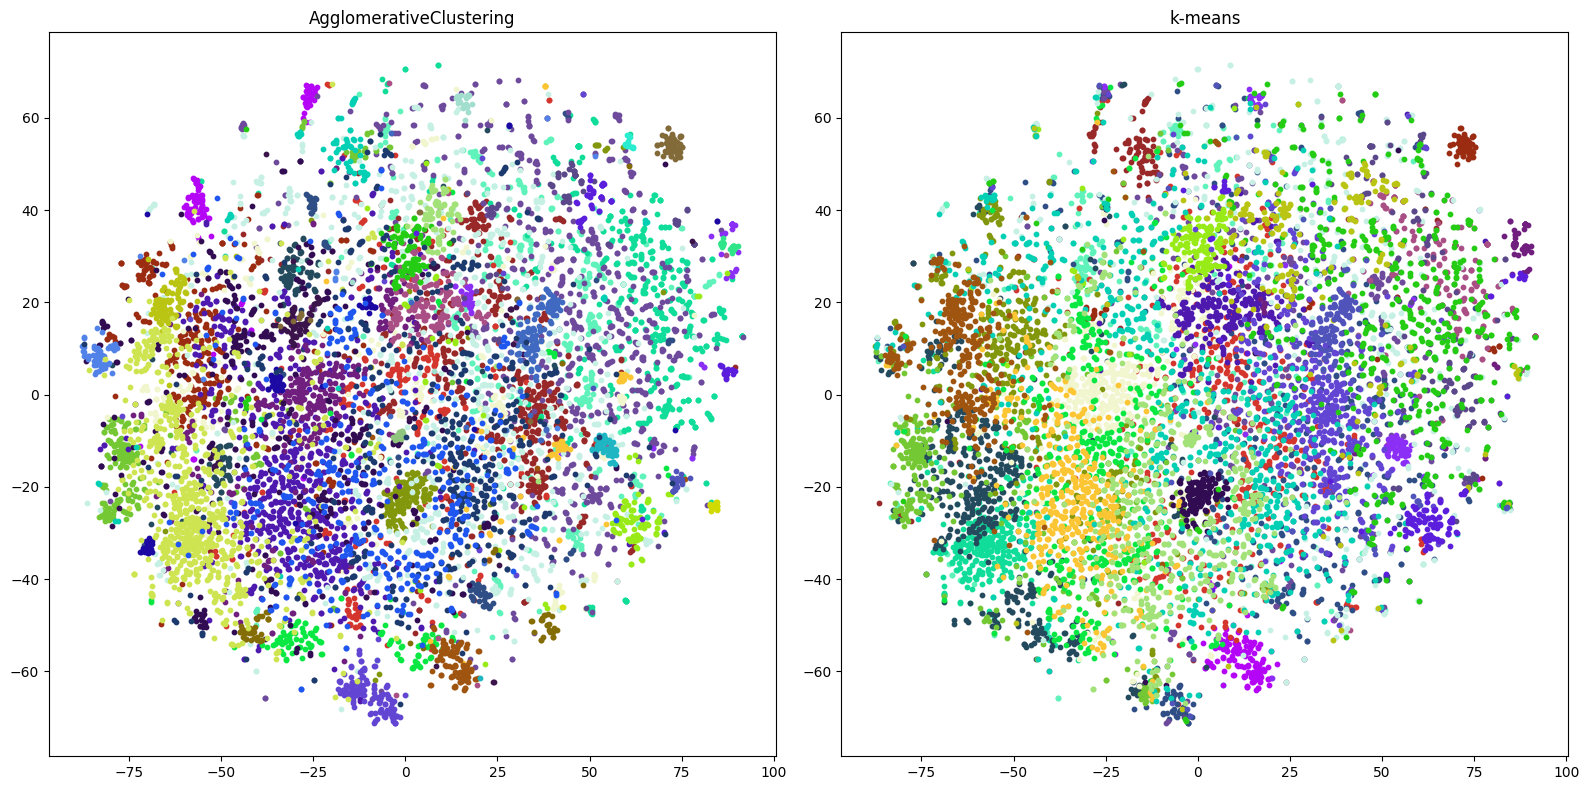

In [413]:
# Построение диаграмм рассеяния

fig = plt.figure(figsize=(16, 8))

for i, labels in enumerate([labels_ac, labels_km]):
    fig.add_subplot(1, 2, i+1, title='AgglomerativeClustering' if i == 0 else 'k-means')
    my_scatter(dots, labels)
    
plt.tight_layout()
plt.show()

Для построения интерактивной диаграммы рассеяния используется AgglomerativeClustering с n_clusters = 45

In [414]:
df_sample['label'] = labels_ac

In [415]:
# Добавление меток кластеров и координаты на плоскости в оригинальный DataFrame

df_orig['label'] = [None]*df_orig.shape[0]
df_orig['label'].loc[df_sample.index] = labels_ac
df_orig['dotx'] = [None]*df_orig.shape[0]
df_orig['doty'] = [None]*df_orig.shape[0]
df_orig['dotx'].loc[df_sample.index] = dots[:, 0]
df_orig['doty'].loc[df_sample.index] = dots[:, 1]

In [429]:
# Запись расширенного DataFrame в файл

with open('clust_comments.csv', 'w') as file:
    df_orig.to_csv(file)

In [431]:
# Чтение расширенного DataFrame из файла

with open ('clust_comments.csv', 'r') as file:
    dfplot = pd.read_csv(file)

# Построение интерактивной диаграммы рассеяния

def fill_text(text, width=70):
    if len(text) > width:
        return "<br>".join(tw.wrap(text,width=width))
    else:
        return text

def rand_color_map(num_clust):
    randomizer = np.random.RandomState(42)
    color_map = {} 
    for k, v in zip(range(num_clust), [tuple(randomizer.randint(0, 256, 3)) for _ in range(num_clust)]):
        color_map[str(k)] = 'rgb' + str(v)
    return color_map
  
dfplot = dfplot.dropna()
dfplot['label'] = dfplot['label'].astype(int).astype(str)
    
dfplot['textOriginal'] = dfplot['textOriginal'].apply(fill_text)

num_clust = rand_color_map(np.unique(labels_ac).__len__())
fig = px.scatter(dfplot, x='dotx', y='doty', color='label', color_discrete_map=num_clust, hover_name='textOriginal', height=800, width=1200)
fig.update_layout(xaxis_title=None, yaxis_title=None)
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br><br>label=%{data.name}<br><extra></extra>', marker=dict(size=7))
fig.show()